# EPG silencing

In [11]:
import numpy as np
import os
import time
import scipy
import glob
import sys
from datetime import datetime
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

import importlib
import pandas as pd
import scipy.stats as spstats

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil
import plotting as putil
import google_drive as gdrive

import re

In [2]:
importlib.reload(util)
util.set_sns_style(style='dark')
%matplotlib notebook

In [3]:
# if util.get_os() == 'Linux':
#     rootdir = '/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data'
# elif util.get_os() == 'Darwin':
#     rootdir = '/home/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data'
# else:
#     rootdir=None
#     print("Unknown os: {}".format(util.get_os()))
rootdir = util.get_rootdir()
experiment = 'EPG_GtACR1'

src_dir = os.path.join(rootdir, 'EPG_inhibition')
# # src_dir = '/Users/julianarhee/Documents/rutalab/data/test'
# print(src_dir)
fig_id = os.path.join('/Edge_Tracking', rootdir.split('/Edge_Tracking/')[1], experiment)
print(fig_id)
savedir = '{}/jyr/{}'.format(rootdir, experiment)
savedir = savedir.replace(" ", "")
figdir = os.path.join(savedir, 'figures')
print("Saving figures to:{}    {}".format('\n', figdir))
if not os.path.exists(figdir):
    os.makedirs(figdir)

/Edge_Tracking/Data/EPG_GtACR1
Saving figures to:
    /home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/EPG_GtACR1/figures


In [4]:
importlib.reload(butil)

importlib.reload(gdrive)

<module 'google_drive' from '/home/julianarhee/Repositories/plume-tracking/google_drive.py'>

#### GtACR1 has specified files from Andy

In [5]:
print(experiment)
loginfo_fpath = os.path.join(savedir, 'info.pkl')

if os.path.exists(loginfo_fpath):
    logdf = gdrive.load_gdrive_df(loginfo_fpath)
else:
    logdf = gdrive.get_info_from_gsheet(experiment)
logdf.shape

EPG_GtACR1


(146, 6)

## safe copy to my folder

In [6]:
copy_files=False
# -------------------------------------------------------------------------
if copy_files:
    import shutil
    if not os.path.exists(os.path.join(savedir, 'raw')):
        os.makedirs(os.path.join(savedir, 'raw'))
    for fpath in glob.glob(os.path.join(src_dir, 'logs', '*.log')): #logdf['filepath'].values:
        fbase = os.path.split(fpath)[-1]
        if not os.path.exists(os.path.join(savedir, 'raw', fbase)):
            shutil.copy(fpath, os.path.join(savedir, 'raw', fbase))

src_dir = os.path.join(savedir, 'raw')
len(sorted(os.listdir(src_dir), key=util.natsort))
copy_files=False


In [7]:
print(src_dir)
len(sorted(os.listdir(src_dir), key=util.natsort))

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/EPG_GtACR1/raw


154

In [8]:
copy_files=False

## add full filepaths to raw log

In [13]:
# logdf = gdrive.get_info_from_gsheet(experiment)
# logdf.shape

if 'filepath' not in logdf.columns:
    print("Finding filepaths...")
    logdf['filepath'] = None
    #curr_fns = logdf[logdf['experiment']=='inside']['log'].values
    curr_fns = logdf['log'].values
    for fn in curr_fns:
        found_files=[]
        #print(fn)
        #fn = fn.replace('-UAS', '_UAS')
        #fn = fn.replace('-EPG', '_EPG')
        #fn = fn.replace('-lights', '_lights')
        voe_datestr = re.findall('\d{8}-\d{6}', fn)[0]

        found_files = glob.glob(os.path.join(src_dir, '{}*.log'.format(voe_datestr)))
        assert len(found_files)==1, "No file found, checking one dir up."
        #if len(found_files)==1:
        #print(found_files)
        fbase = os.path.split(found_files[0])[-1]
        # save full path
        logdf.loc[logdf['log']==fn, 'filepath'] = found_files[0] 
        # make sure correct filename is saved:
        logdf.loc[logdf['log']==fn, 'log'] = fbase
    # save
    import _pickle as pkl
    gdrive.save_gdrive_df(logdf, loginfo_fpath)


COMPLETE: Data copied
Finding filepaths...


In [14]:
logdf[(logdf['log']=='04122022-121823_UAS-GtACR1_lights_on')]

,Fly,Genotype,log,lights,experiment,filepath


## check LED activation inside/outside

In [15]:
fn = '04132022-101244_EPG_GtACR1_lights_off.log'

fpath = os.path.join(src_dir, fn)
df0 = pd.read_csv(fpath, encoding='latin' )
df = butil.load_dataframe(fpath, experiment=experiment)
df = butil.correct_manual_conditions(df, experiment, logdf=logdf)
df = butil.process_df(df)
print(df0.columns)

Correcting experiment conditions: EPG_GtACR1
Index(['timestamp -- motor_step_command', 'mfc1_stpt', 'mfc2_stpt',
       'mfc3_stpt', 'led1_stpt', 'led2_stpt', 'sig_status', 'ft_posx',
       'ft_posy', 'ft_frame', 'ft_error', 'ft_roll', 'ft_pitch', 'ft_yaw',
       'ft_heading', 'adapted_center', 'instrip', 'strip_thresh'],
      dtype='object')


In [16]:
df['condition'].unique()

array(['lights-off'], dtype=object)

<IPython.core.display.Javascript object>


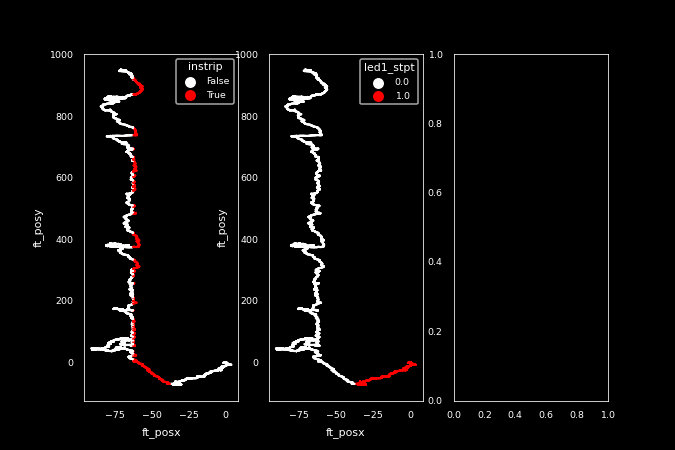

<IPython.core.display.Javascript object>


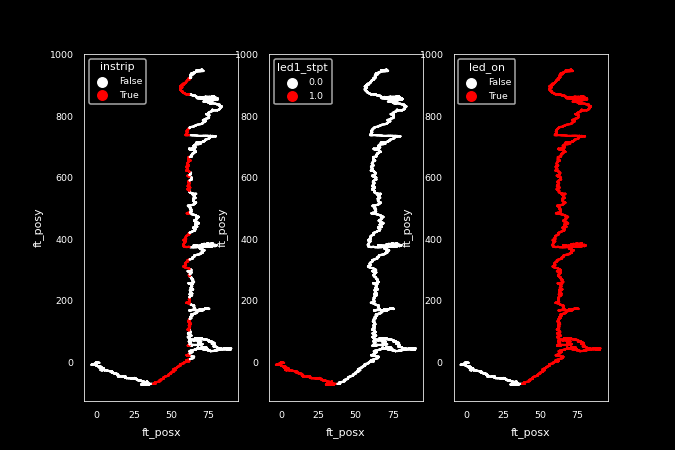

<AxesSubplot: xlabel='ft_posx', ylabel='ft_posy'>

In [17]:
fig, axn = pl.subplots(1,3)
sns.scatterplot(data=df0, x='ft_posx', y='ft_posy', hue='instrip', ax=axn[0],
                palette={True: 'r', False: 'w'}, s=2, edgecolor='none')
sns.scatterplot(data=df0, x='ft_posx', y='ft_posy', hue='led1_stpt', ax=axn[1],
                palette={True: 'r', False: 'w'}, s=2, edgecolor='none')

fig, axn = pl.subplots(1,3)
sns.scatterplot(data=df, x='ft_posx', y='ft_posy', hue='instrip', ax=axn[0],
                palette={True: 'r', False: 'w'}, s=2, edgecolor='none')
sns.scatterplot(data=df, x='ft_posx', y='ft_posy', hue='led1_stpt', ax=axn[1],
                palette={True: 'r', False: 'w'}, s=2, edgecolor='none')
sns.scatterplot(data=df, x='ft_posx', y='ft_posy', hue='led_on', ax=axn[2],
                palette={True: 'r', False: 'w'}, s=2, edgecolor='none')

# Get combined df

In [18]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

In [19]:
create_new=True
strip_width=50
strip_sep=1000
# ---------------------------------
# log_files = butil.get_log_files(src_dir=src_dir, experiment=experiment, logdf=logdf, verbose=False, is_gdrive=False,
#                         return_loginfo=False)
# is_csv = False
    
df0_all, errors = butil.load_combined_df(log_files=None, logdf=logdf, 
                                 src_dir=src_dir, return_errors=True,
                                is_csv=False, experiment=experiment, 
                                savedir=savedir, save_errors=False, create_new=create_new,
                                parse_filename=True, remove_invalid=True, process=True)
#df0_all = df0_all.reset_index(drop=True)
# Make some fixes
condition_list = df0_all['condition'].unique()
print("Found {} conditions:".format(len(condition_list)))
for c in condition_list:
    print(c)

if create_new: # save
    df_fpath = os.path.join(savedir, 'combined_df.pkl')
    print("Saving combined df to: {}".format(savedir))
    butil.save_df(df0_all, df_fpath)
create_new=False

Processing 154 tracking files.
Creating combined df


/home/julianarhee/Repositories/plume-tracking/behavior.py:313: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(fpath, encoding='latin' )#, sep=",", skiprows=[1], header=0,


[WARNING] ['04122022-173954_UAS-GTACR1_lights_off']: Found bad skips, removing 11377 of 26861 samples.
[WARNING] ['04132022-102220_EPG_GtACR1_lights_on']: Found bad skips, removing 144 of 7604 samples.
[WARNING] ['04132022-113859_UAS-GtACR1_lights_off']: Found bad skips, removing 56 of 6331 samples.
[WARNING] ['04142022-141240_EPG_GtACR1_lights_on']: Found bad skips, removing 117 of 25748 samples.
[WARNING] ['04142022-150525_EPG_GtACR1_lights_on']: Found bad skips, removing 107 of 6036 samples.
[WARNING] ['04142022-151803_EPG_GtACR1_lights_on']: Found bad skips, removing 27 of 6968 samples.
[WARNING] ['04162022-135421_EPG_GtACR1_lights_off']: Found bad skips, removing 15 of 17605 samples.
[WARNING] ['04162022-140353_EPG_GtACR1_lights_off']: Found bad skips, removing 465 of 6299 samples.
[WARNING] ['04182022-122806_UAS-GtACR1_lights_off_0_deg']: Found bad skips, removing 24 of 9465 samples.
[WARNING] ['10182021-135839_ss00096_Fly1_jump_lights_LT_002']: Found bad skips, removing 580 of 2

In [23]:
errors

['04122022-121823_UAS-GtACR1_lights_on',
 '04122022-122456_UAS-GtACR1_lights_on',
 '04122022-122846_UAS-GtACR1_lights_on',
 '04122022-123223_UAS-GTACR1_lights_on',
 '04122022-123840_UAS-GTACR1_lights_on',
 '04142022-155728_UAS_GtACR1_lights_on',
 '04142022-160731_UAS_GtACR1_lights_off',
 '04182022-115254_UAS-GtACR1_15deg_5mms_downwind']

In [ ]:
# Make some fixes
condition_list = df0_all['condition'].unique()
print("Found {} conditions:".format(len(condition_list)))
for c in condition_list:
    print(c)

In [129]:
df_ = butil.load_dataframe(fpath)
df_['filename']

0        04132022-101244_EPG_GtACR1_lights_off
1        04132022-101244_EPG_GtACR1_lights_off
2        04132022-101244_EPG_GtACR1_lights_off
3        04132022-101244_EPG_GtACR1_lights_off
4        04132022-101244_EPG_GtACR1_lights_off
                         ...                  
10281    04132022-101244_EPG_GtACR1_lights_off
10282    04132022-101244_EPG_GtACR1_lights_off
10283    04132022-101244_EPG_GtACR1_lights_off
10284    04132022-101244_EPG_GtACR1_lights_off
10285    04132022-101244_EPG_GtACR1_lights_off
Name: filename, Length: 10286, dtype: object

In [136]:
logfn = '04122022-123223_UAS-GTACR1_lights_on'
logdf[logdf['log']=='{}.log'.format(logfn)]['experiment']


Series([], Name: experiment, dtype: object)

In [66]:
print("There are {} unique fly IDs.".format(len(df0_all['fly_id'].unique())))
df0_all['fly_id'].unique()

14

In [68]:
included_conditions = '0-degree' #'selected':
# ---------------------------------------------------------------
# select dataset
if included_conditions=='0-degree':    
    df = df0_all[df0_all['experiment']=='0'].copy()
    
# make output dirs for figures
curr_figdir = os.path.join(figdir, included_conditions)
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
print(curr_figdir)

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures/all


In [70]:
instrip_palette = {True: 'r', False: 'w'}

# plot all

In [88]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

<IPython.core.display.Javascript object>


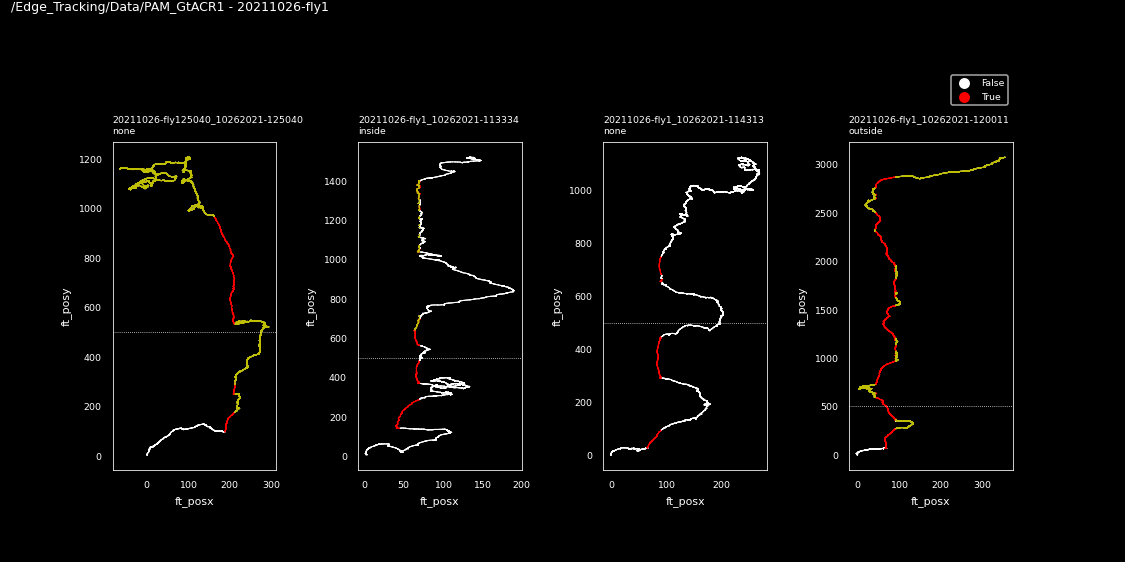

/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


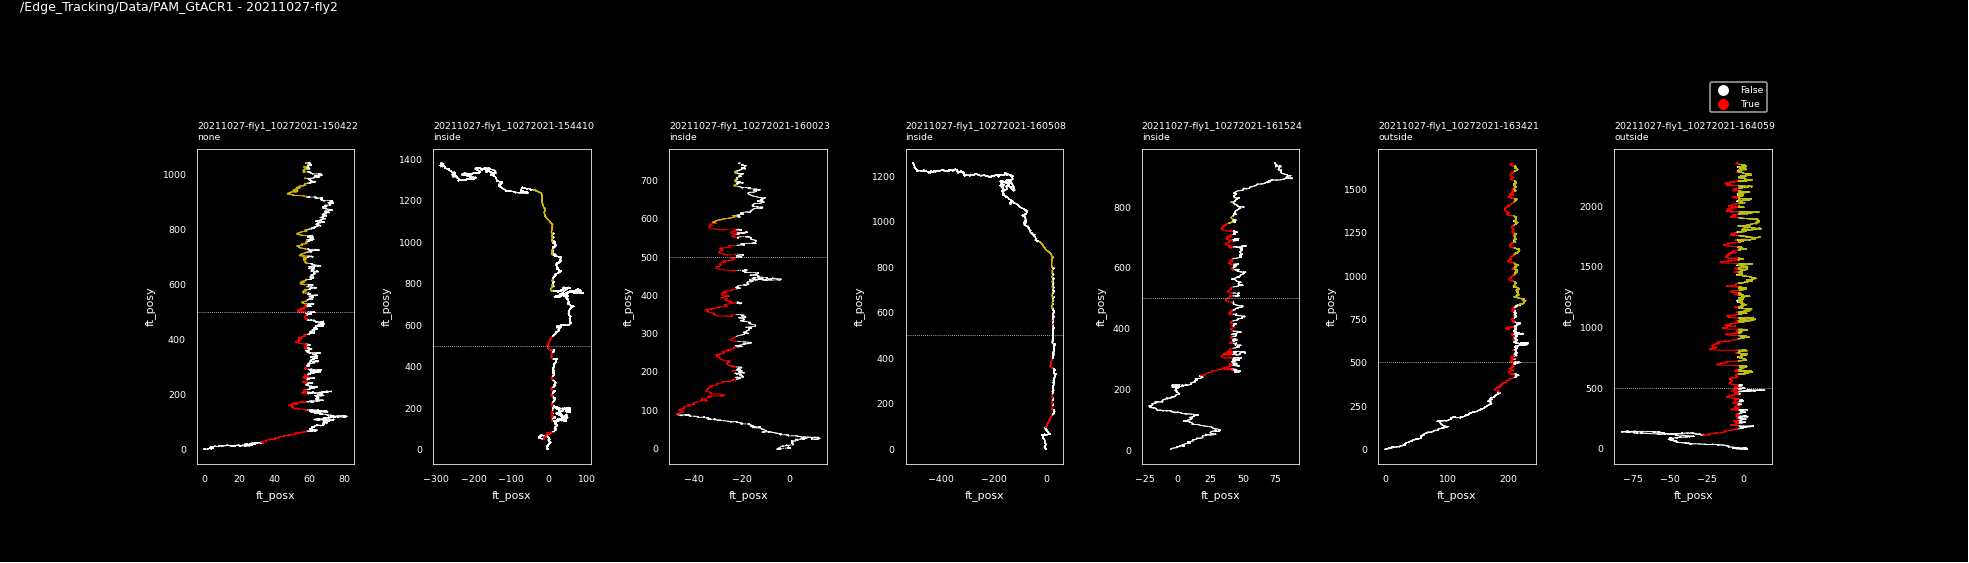

<IPython.core.display.Javascript object>


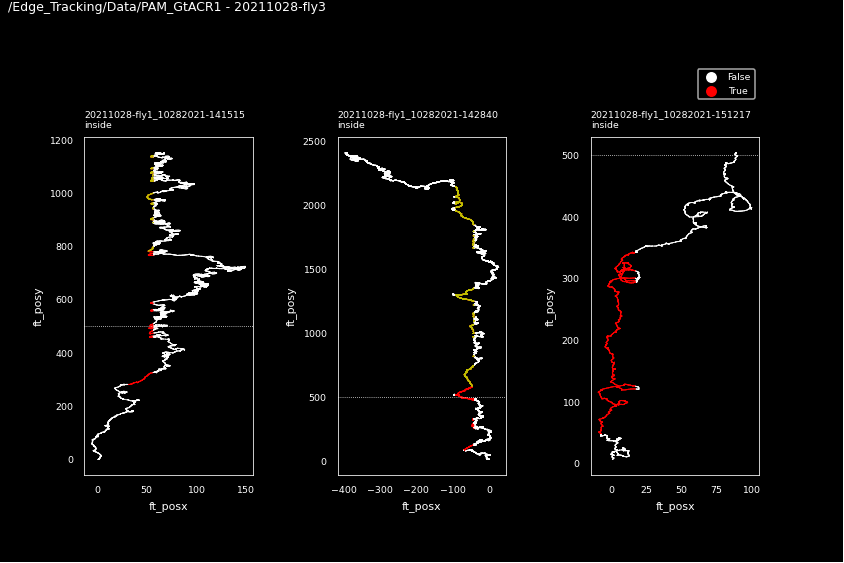

/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


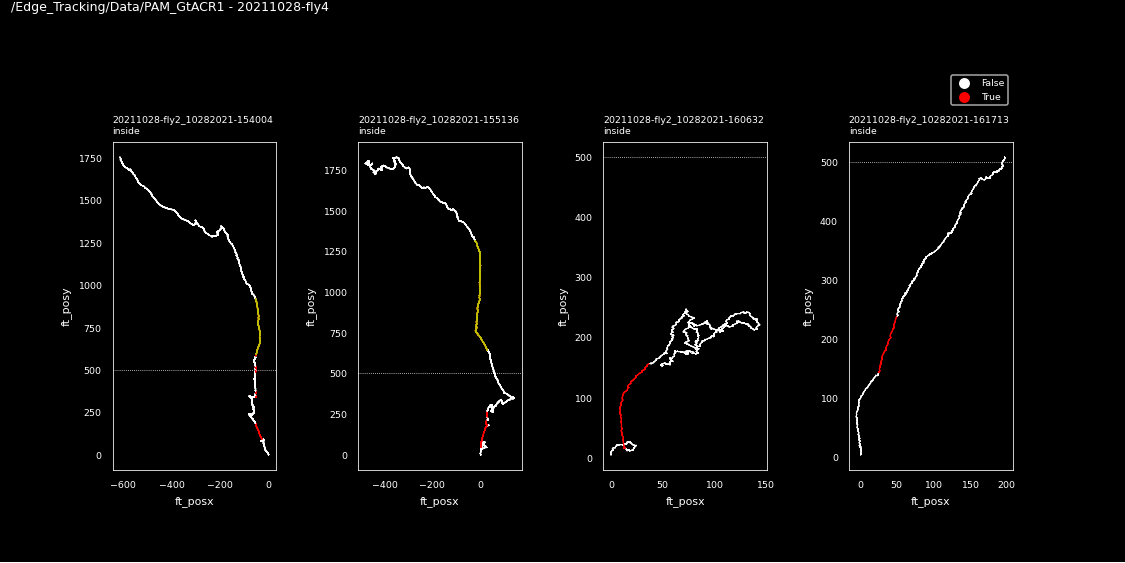

/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


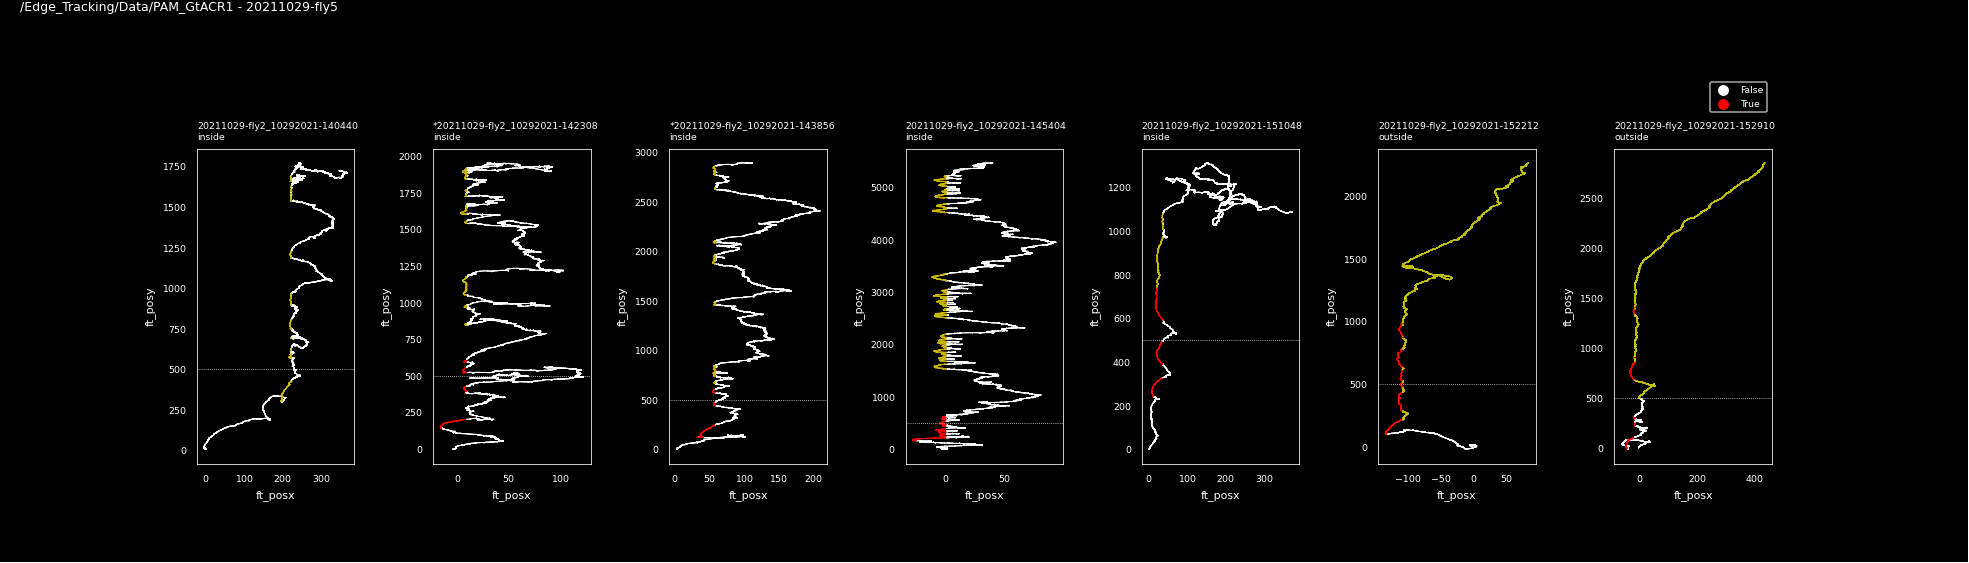

<IPython.core.display.Javascript object>


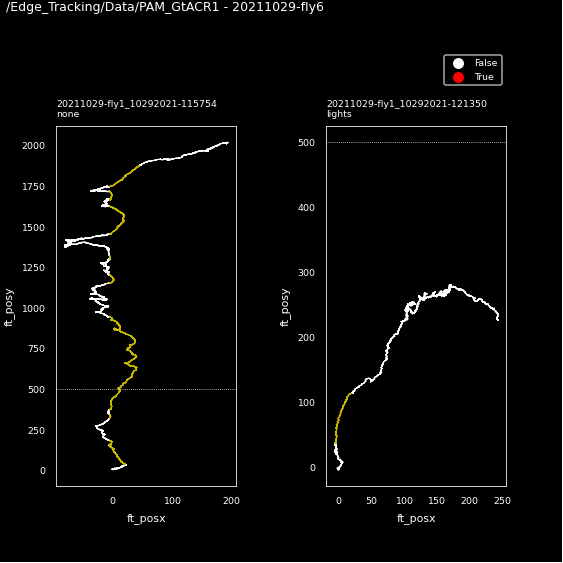

<IPython.core.display.Javascript object>


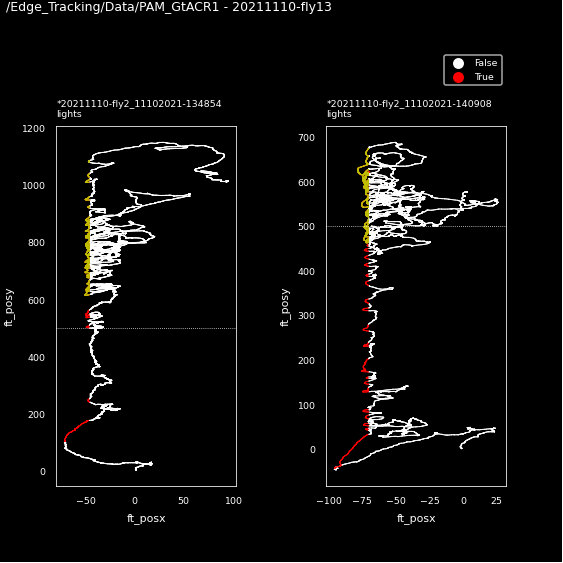

<IPython.core.display.Javascript object>


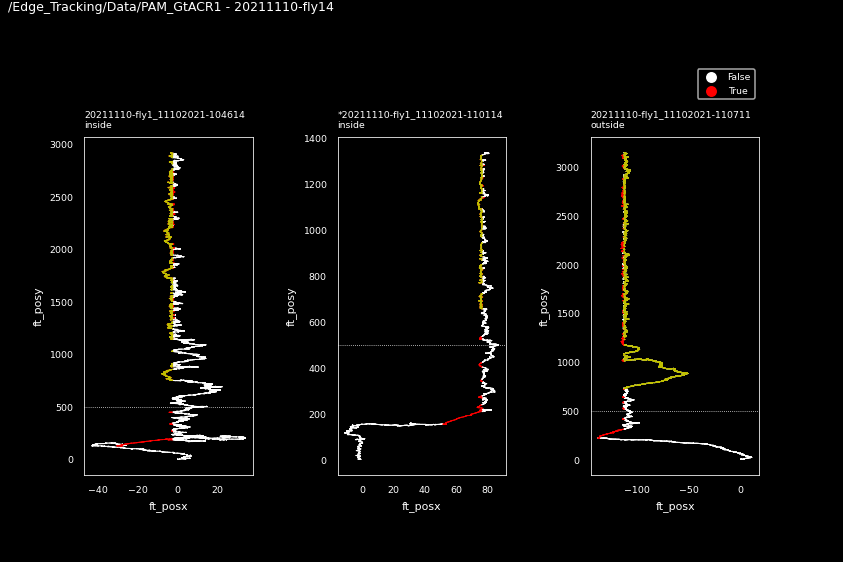

<IPython.core.display.Javascript object>


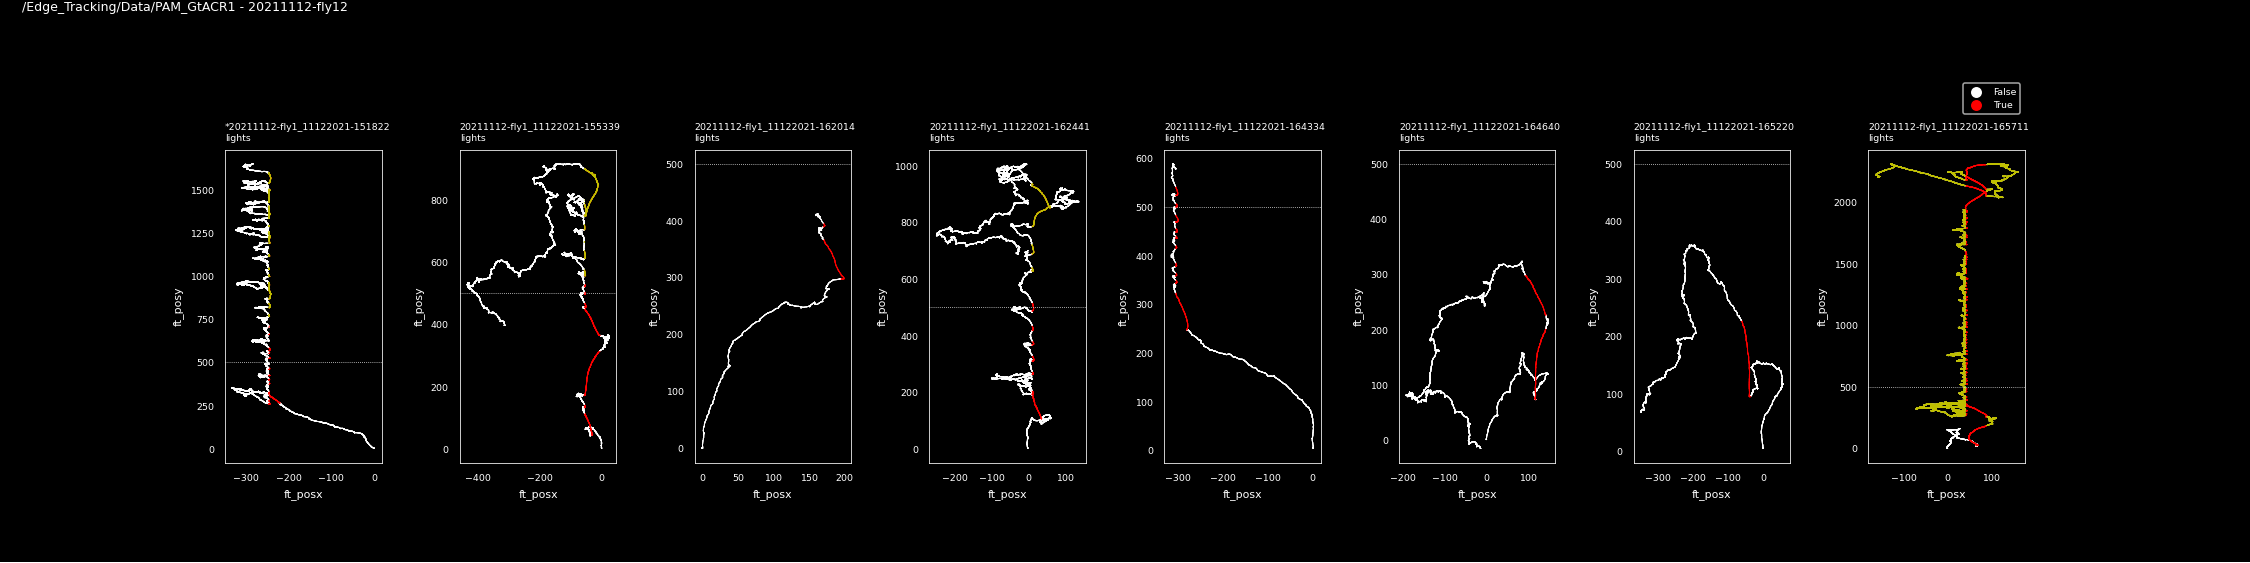

/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


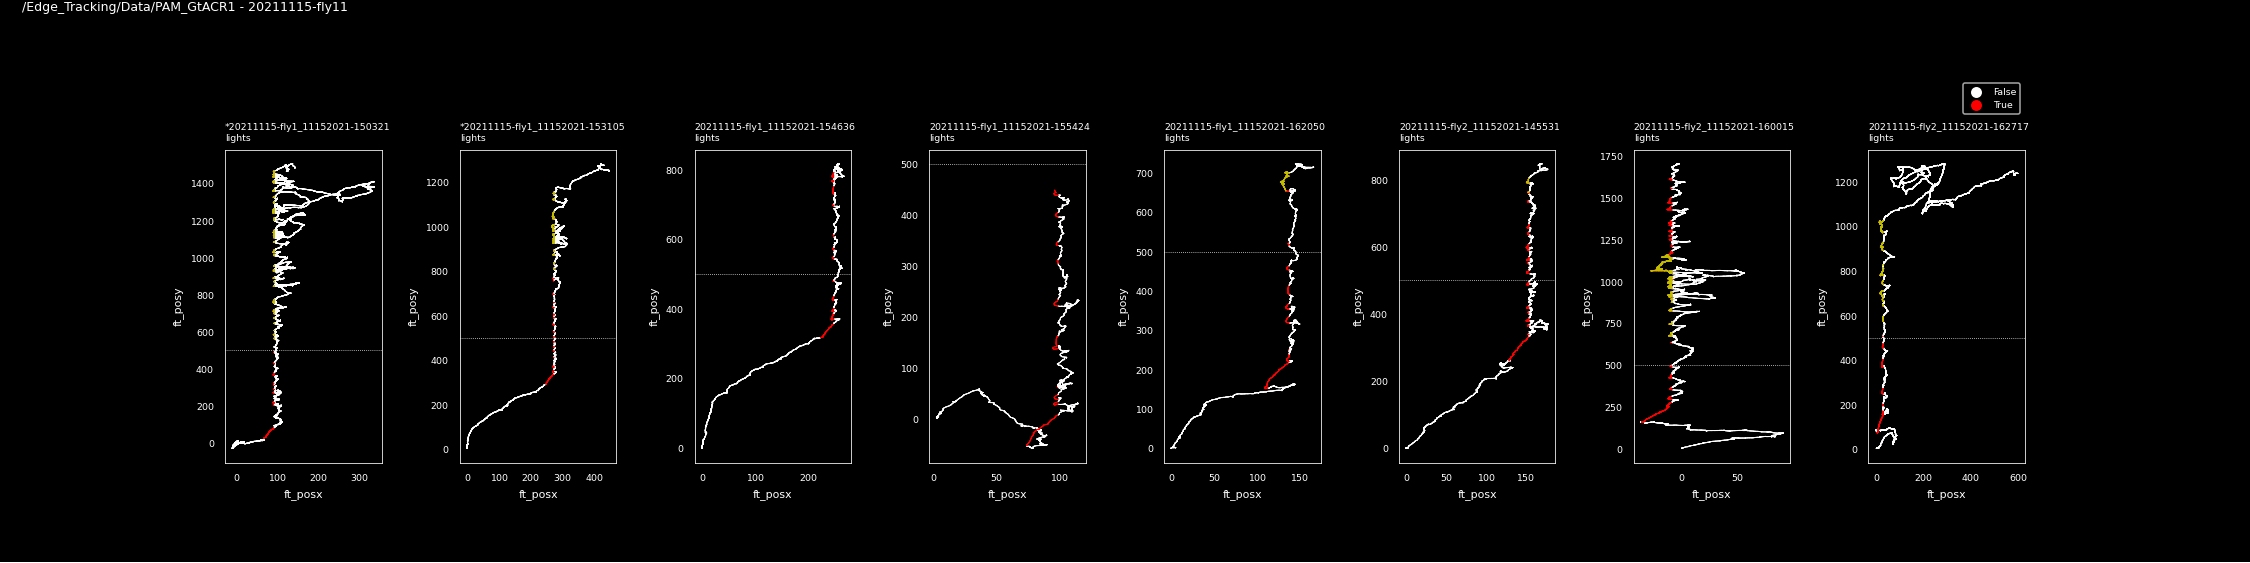

/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


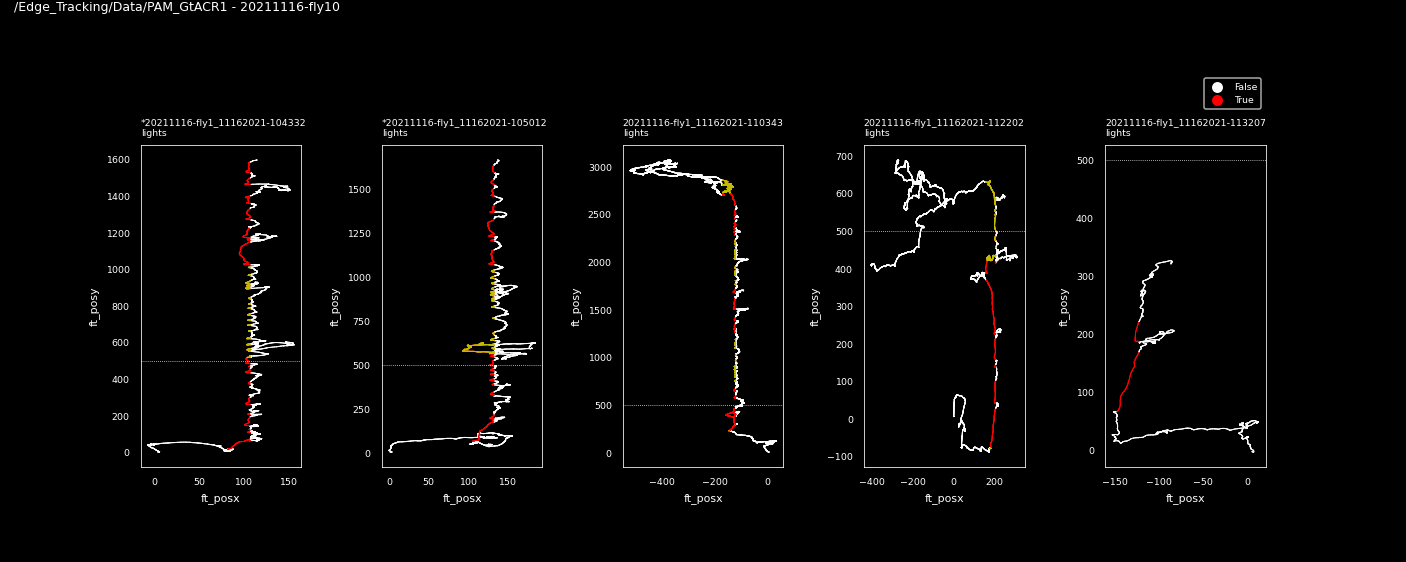

/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


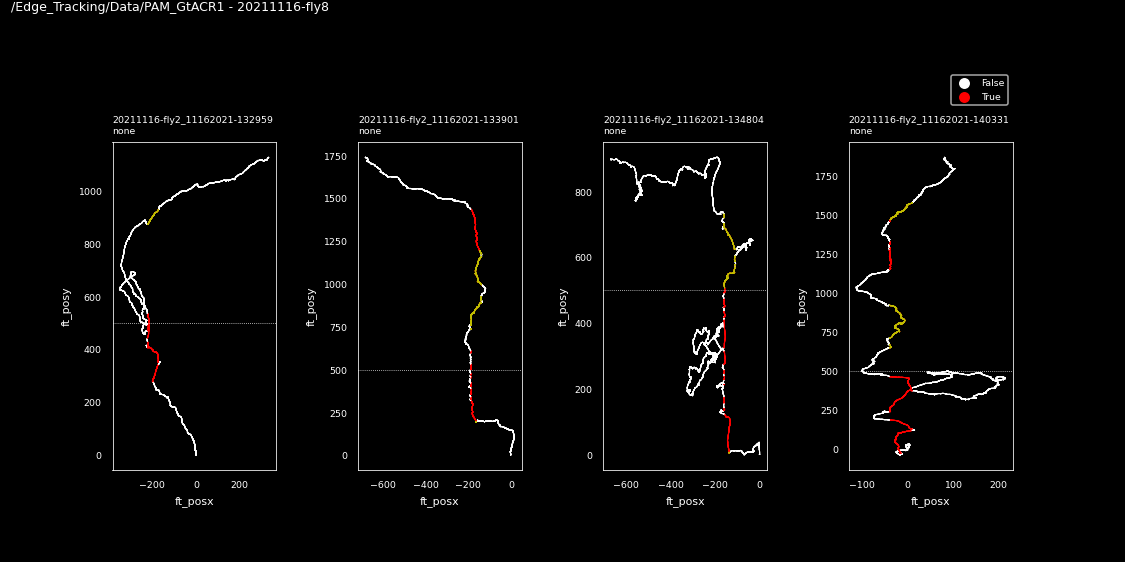

<IPython.core.display.Javascript object>


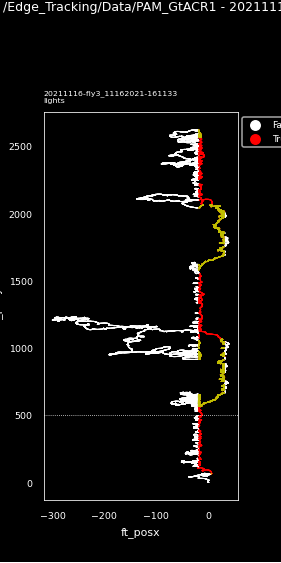

<IPython.core.display.Javascript object>


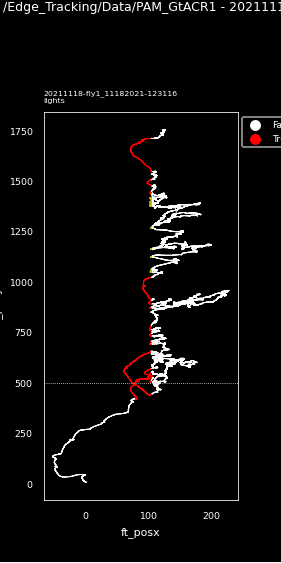

In [71]:

for fly_id, df_ in df.groupby('fly_id'):
    ntrials = len(df_['trial_id'].unique())
    fig, axn = pl.subplots(1, ntrials, figsize=(ntrials*2.5, 5))
    if len(df_['trial_id'].unique())==1:
        sns.scatterplot(data=df_, x="ft_posx", y="ft_posy", hue='instrip', ax=axn,
                        s=.5, edgecolor='none', palette=instrip_palette)
        sns.scatterplot(data=df_[df_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=axn,
                    s=.5, edgecolor='none', palette={0: 'y'}, legend=False)
        axn.set_box_aspect(2)
        axn.axhline(y=500, linestyle=':', c='w', linewidth=0.5)
        if df_['filename'].unique()[0] in incl_logs:
            trial_id = '*{}'.format(df_['trial_id'].unique()[0])
        else:
            trial_id = df_['trial_id'].unique()[0]
        currcond = df_['condition'].unique()[0]
        plot_title = "{}{}{}".format(trial_id, '\n', currcond)
        axn.set_title(plot_title, fontsize=5, loc='left')
        axn.legend(bbox_to_anchor=(1,1), loc='upper left')
    else:
        for ai, (ax, (trial_id, tdf_)) in enumerate(zip(axn.flat, df_.groupby('trial_id'))):
            sns.scatterplot(data=tdf_, x="ft_posx", y="ft_posy", hue='instrip', ax=ax,
                            s=.5, edgecolor='none', palette=instrip_palette)
            sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
                    s=.5, edgecolor='none', palette={0: 'y'}, legend=False)
            ax.set_box_aspect(2)
            ax.axhline(y=500, linestyle=':', c='w', linewidth=0.5)
            if tdf_['filename'].unique()[0] in incl_logs:
                trial_id = '*{}'.format(tdf_['trial_id'].unique()[0])
            else:
                trial_id = tdf_['trial_id'].unique()[0]
            currcond = tdf_['condition'].unique()[0]
            plot_title = "{}{}{}".format(trial_id, '\n', currcond)
            ax.set_title(plot_title, fontsize=6, loc='left')
            if ai == (ntrials-1):
                ax.legend(bbox_to_anchor=(1,1.1), loc='lower right')
            else:
                ax.legend_.remove()
    pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, top=0.8)
    util.label_figure(fig, '{} - {}'.format(fig_id, fly_id))
    pl.savefig(os.path.join(curr_figdir, '{}.png'.format(fly_id)))

In [82]:
# exclude weird/unknown conditions:

exclude = [
    '10262021-125040_PAMGtACR1_no_lights_strip', 
    '10262021-120011_PAMGtACR1_lights_outside_Fly1_003',
    '11162021-161133_PAMGtACR1_Fly3_006', 
    '11122021-165711_PAMGtACR1_Fly1_008'
]

df = df0_all[(df0_all['condition'].isin(['inside', 'lights'])) & (~df0_all['filename'].isin(exclude))].copy()


In [83]:
trial_counts = df[['fly_id', 'filename']].drop_duplicates().groupby('fly_id').count()

nr = len(df['fly_id'].unique())
nc = int(trial_counts.max())
print(nr, nc)

12 8


In [92]:
importlib.reload(putil)

<module 'plotting' from '/home/julianarhee/Repositories/plume-tracking/plotting.py'>

<IPython.core.display.Javascript object>


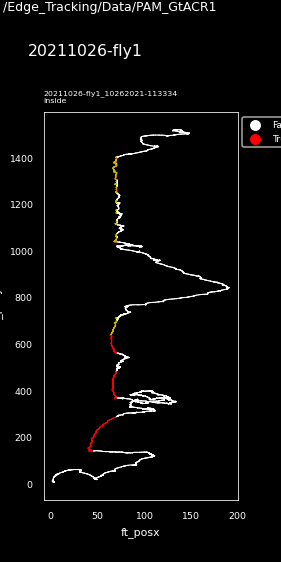

<IPython.core.display.Javascript object>


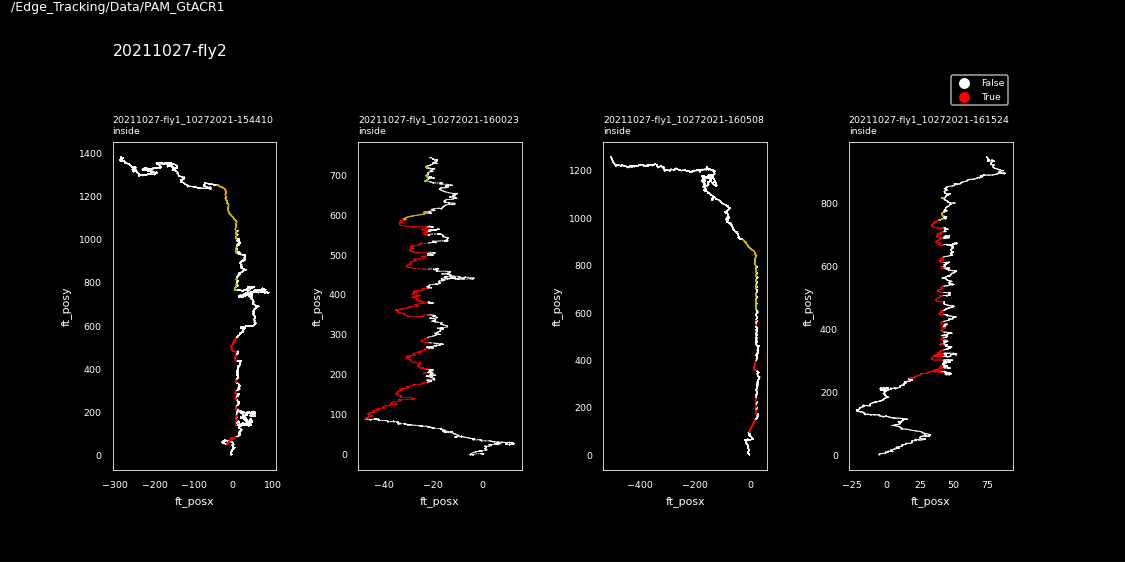

<IPython.core.display.Javascript object>


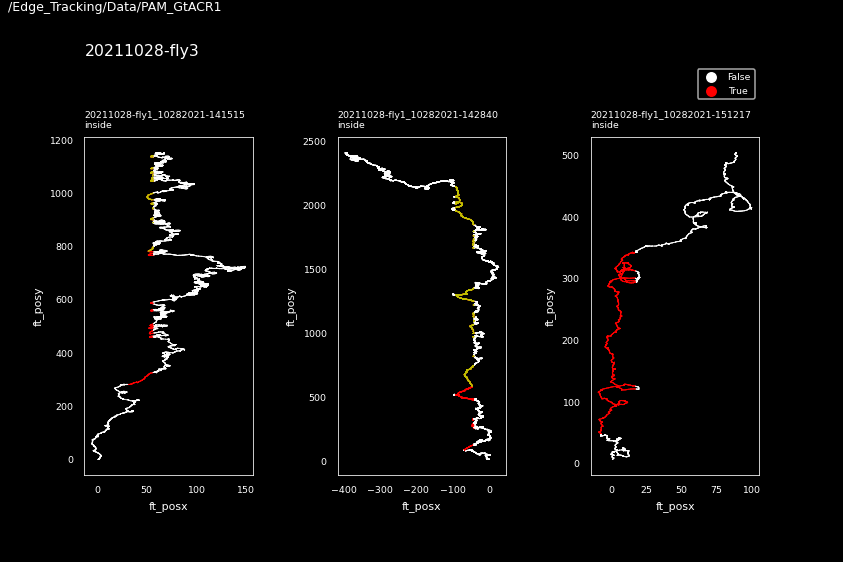

/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/home/julianarhee/Repositories/plume-tracking/plotting.py:147: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  if len(df_['trial_id'].unique())==1:


<IPython.core.display.Javascript object>


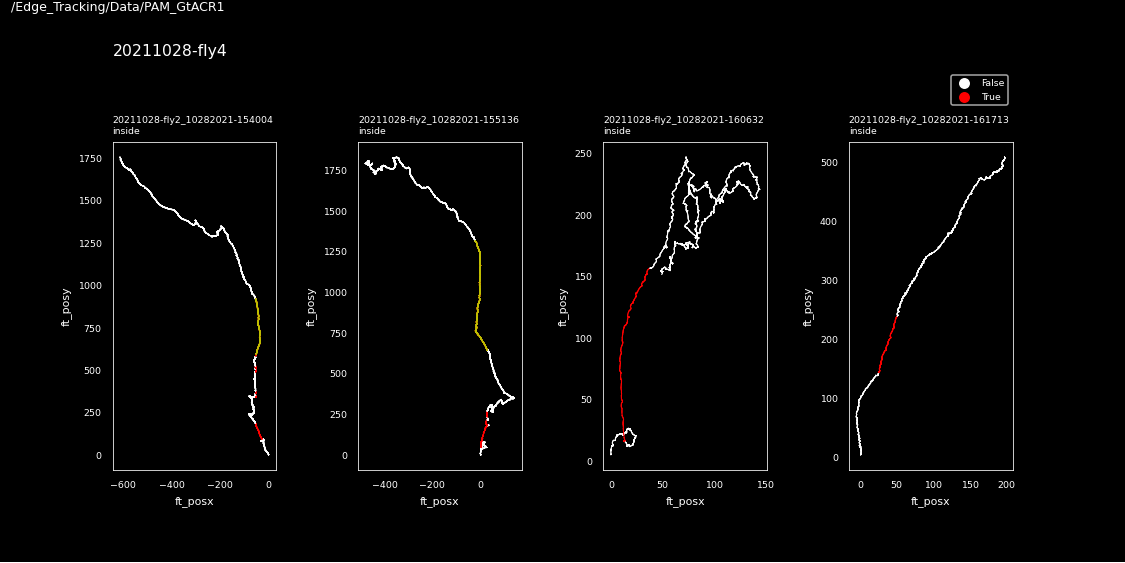

/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


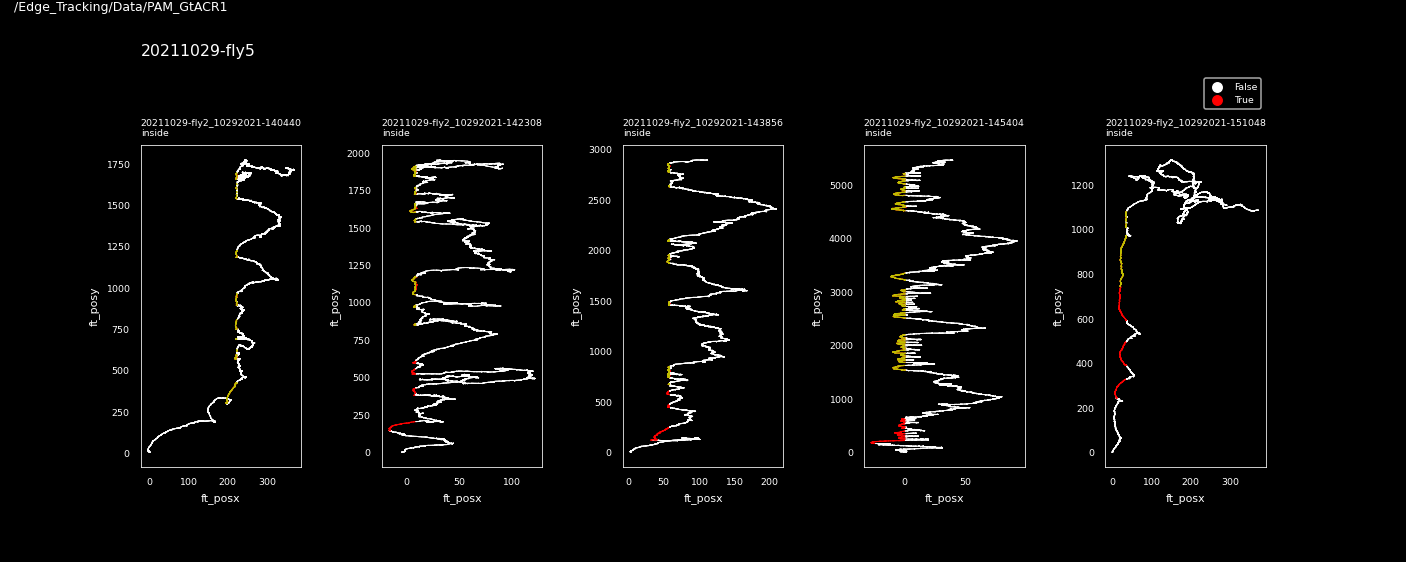

<IPython.core.display.Javascript object>


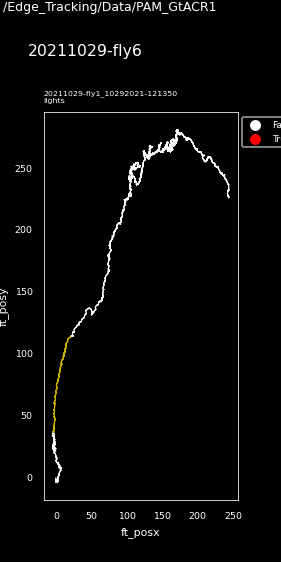

<IPython.core.display.Javascript object>


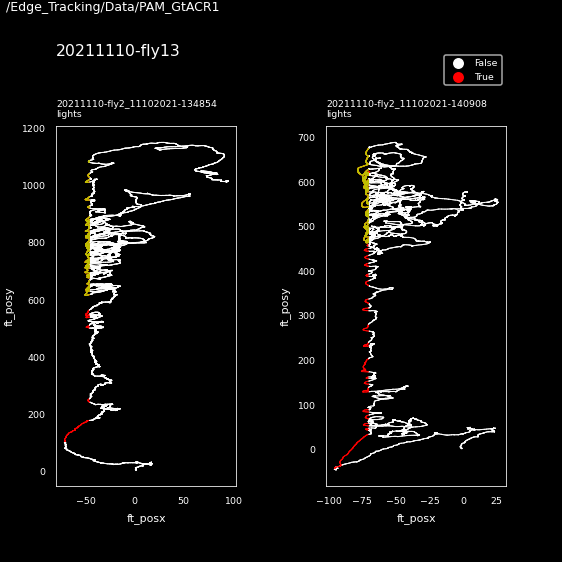

<IPython.core.display.Javascript object>


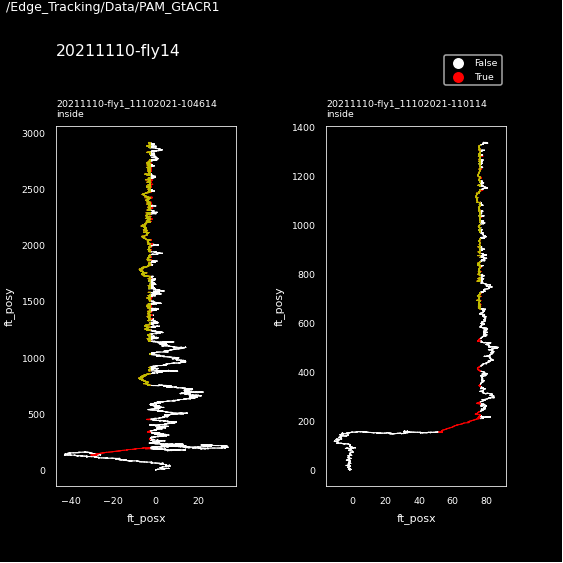

<IPython.core.display.Javascript object>


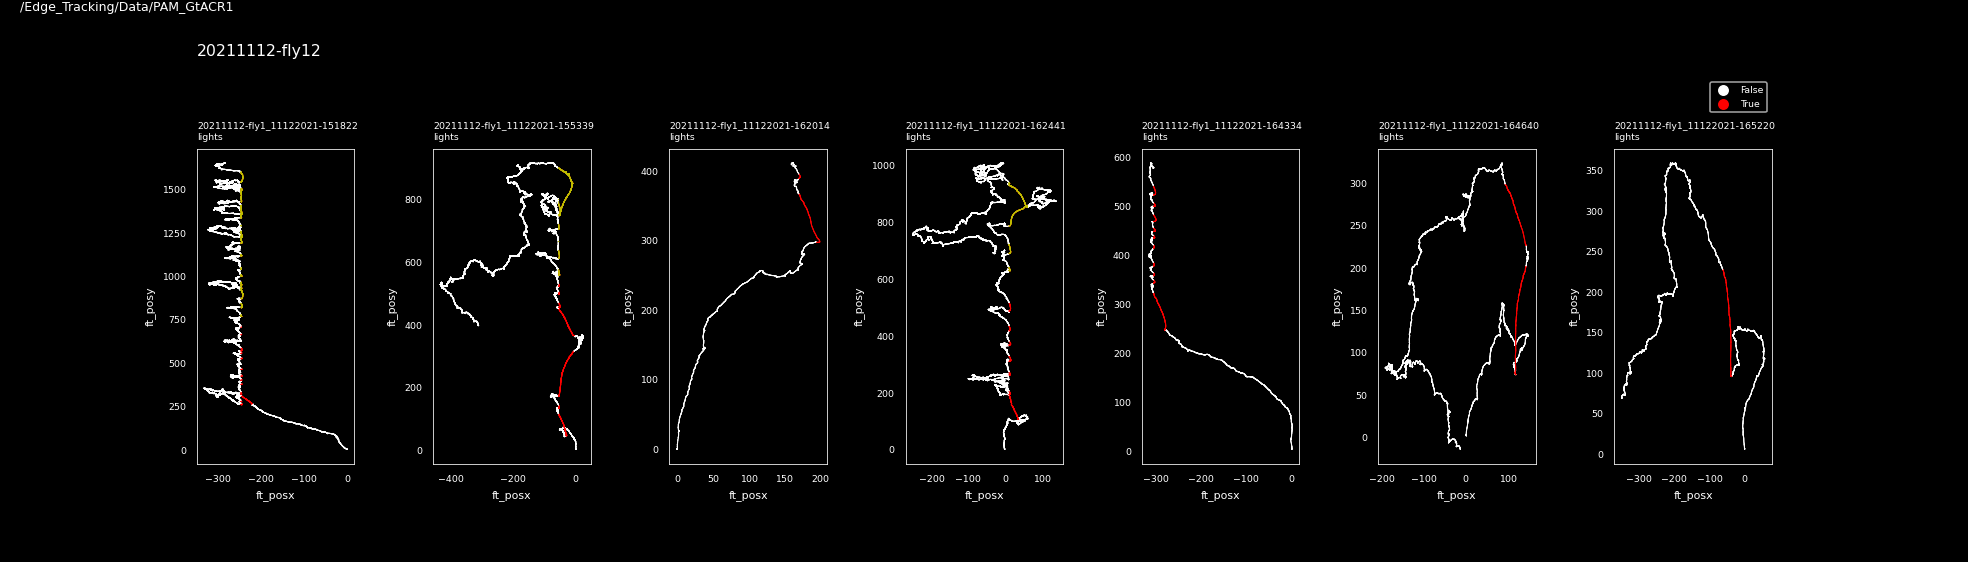

/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


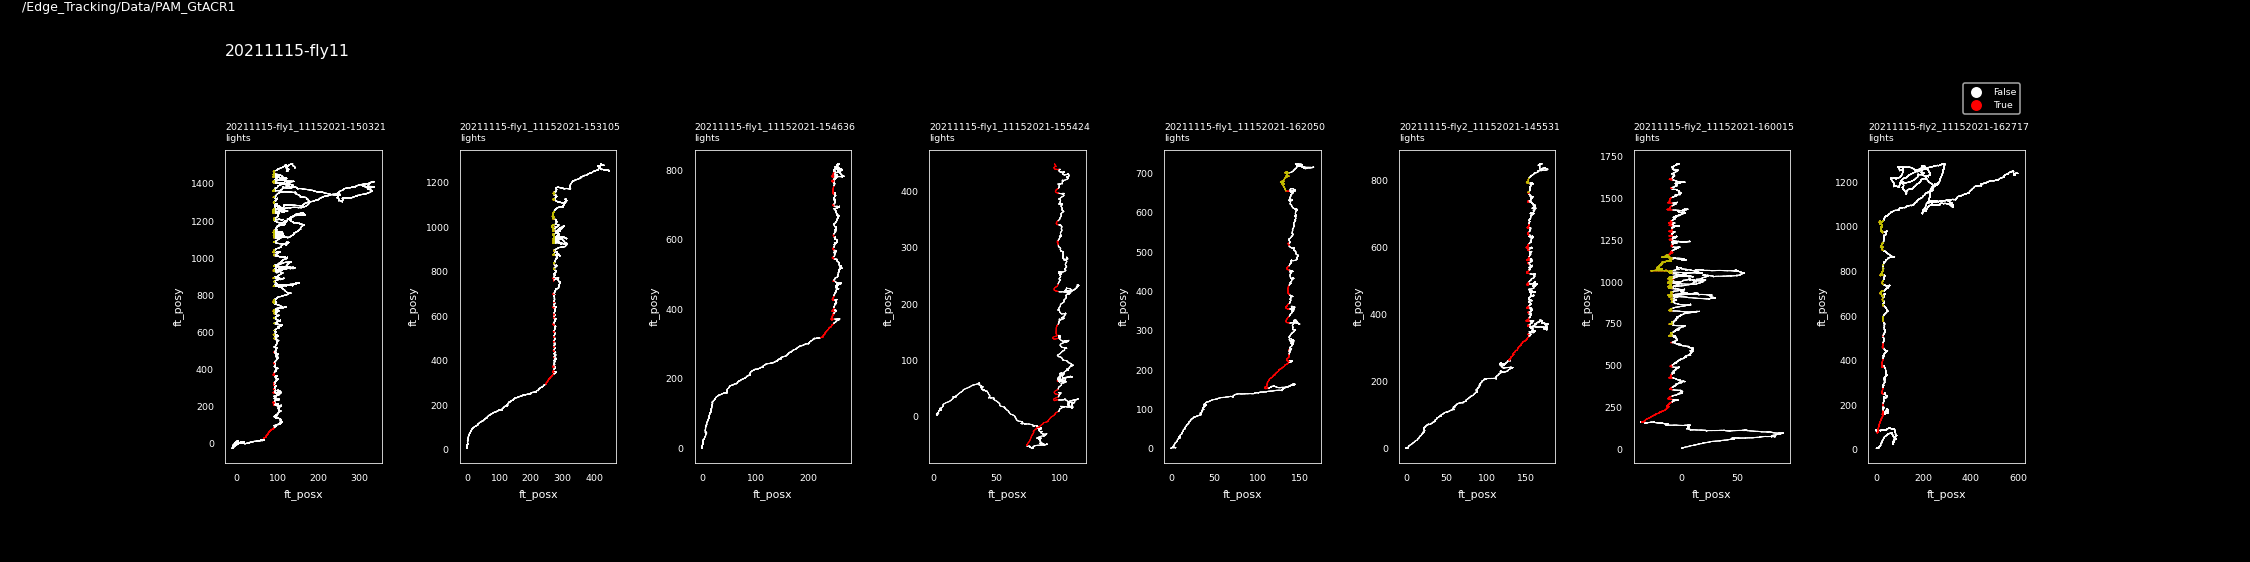

/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


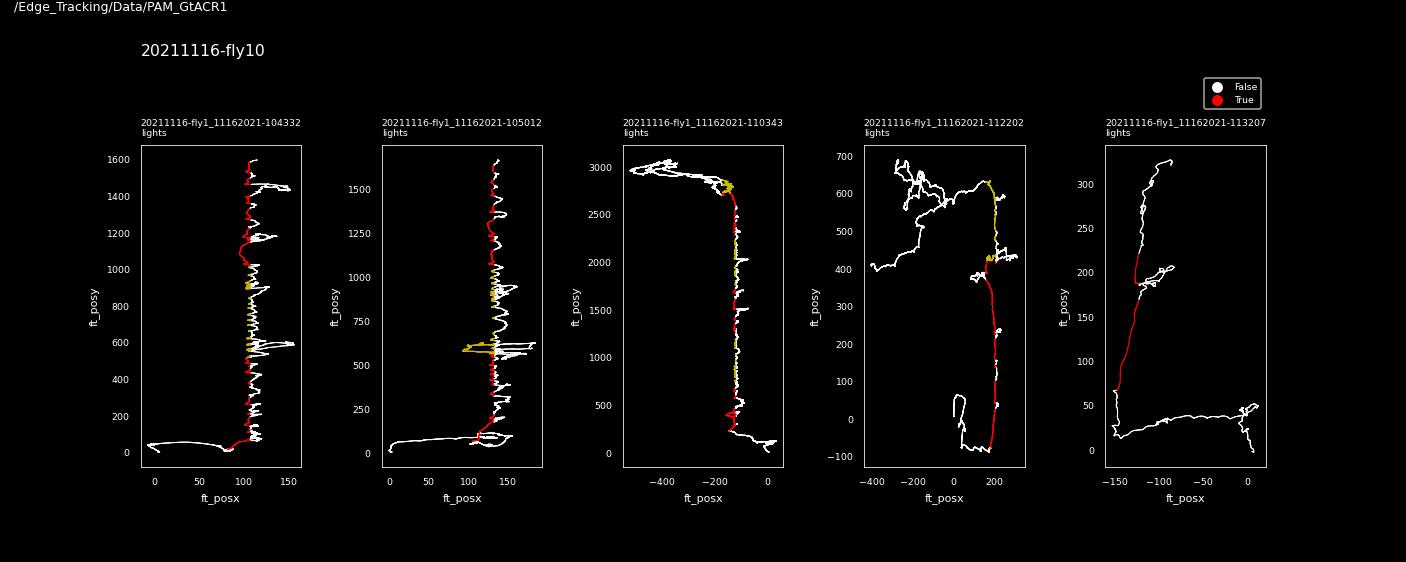

/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


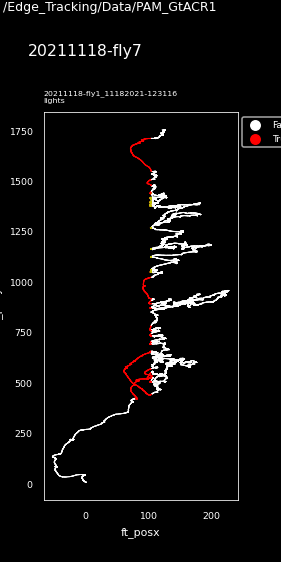

In [95]:

for ri, (fly_id, flydf) in enumerate(df.groupby('fly_id')):
    fig = putil.plot_one_flys_trials(flydf)
    pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, top=0.8)
    util.label_figure(fig, fig_id)
    fig.text(0.1, 0.9, fly_id) #'{} - {}'.format(fig_id, fly_id))

In [211]:
fly_id = '20211110-fly13'
df_ = df[df['fly_id']==fly_id].copy()
df_['trial_id'].unique()
    

array(['20211110-fly2_11102021-134854', '20211110-fly2_11102021-140908'],
      dtype=object)

In [243]:
strip_borders={}
for trial_id, d_ in df_.groupby('trial_id'):
    curr_borders = butil.find_strip_borders(d_, strip_width=50, is_grid=False)
    strip_borders[trial_id] = curr_borders
strip_borders

{'20211110-fly2_11102021-134854': [(46.39522462439108, 96.414856227559)],
 '20211110-fly2_11102021-140908': [(70.24675544542139, 120.246757837264)]}

In [294]:
import seaborn as sns

In [304]:
colors = mpl.cm.coolwarm(np.linspace(0, 1, 2))
hue_values = [True, False]
cdict = dict((k, v) for k, v in zip(hue_values, colors))


In [326]:
trial_id = '20211110-fly2_11102021-140908'
start_ix = df_[(df_['trial_id']==trial_id) & (df_['instrip'])].iloc[0].name
d_ = df_[df_['trial_id']==trial_id].loc[start_ix:]
curr_borders = strip_borders[trial_id]